In [4]:
from scipy.stats.stats import pearsonr, spearmanr
from sklearn.metrics import r2_score, mean_squared_error
import statistics
from math import sqrt
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np



datadir = "/data/Shilab/sjwon3789/selectivity_models/models_C33_200/"
datadir_DNN = "/data/Shilab/sjwon3789/selectivity_models/models_C33_200/"

output_dir = "output_dir_DNNxML"

def stats(y_true, y_pred):
    Rs = spearmanr(y_true, y_pred)[0]
    Rp = pearsonr(y_true, y_pred)[0]
    R2 = r2_score(y_true, y_pred)
    RMSE = sqrt(mean_squared_error(y_true, y_pred))
    return Rp, Rs, R2, RMSE


def predict_method(df, method):
    y_pred = list(df[method])
    y_true = list(df['exp_mean'])

    Rp, Rs, R2, RMSE = stats(y_true, y_pred)
    return Rp, Rs, R2, RMSE

In [9]:
def get_merged_df(model_dir, i):
    # Define a list of model directories
    # Create an empty list to store the results for each model
    results = []

    # Loop through each model directory
    # for model_dir in model_directories:
    # Create empty lists to store Rp, Rs, R2, and RMSE values for each method
    rp_values_consensus = []
    rs_values_consensus = []
    r2_values_consensus = []
    rmse_values_consensus = []

    rp_values_xgb = []
    rs_values_xgb = []
    r2_values_xgb = []
    rmse_values_xgb = []

    rp_values_rf = []
    rs_values_rf = []
    r2_values_rf = []
    rmse_values_rf = []

    rp_values_dnn = []
    rs_values_dnn = []
    r2_values_dnn = []
    rmse_values_dnn = []

    # Create empty lists to store max values for Rp, Rs, and R2, and min value for RMSE
    max_rp_values_consensus = []
    max_rs_values_consensus = []
    max_r2_values_consensus = []
    min_rmse_values_consensus = []

    max_rp_values_xgb = []
    max_rs_values_xgb = []
    max_r2_values_xgb = []
    min_rmse_values_xgb = []

    max_rp_values_rf = []
    max_rs_values_rf = []
    max_r2_values_rf = []
    min_rmse_values_rf = []

    max_rp_values_dnn = []
    max_rs_values_dnn = []
    max_r2_values_dnn = []
    min_rmse_values_dnn = []

    # Loop through different values of i
    # for i in range(10):  # Assuming you have 10 values of i (0 to 9)
    df1 = pd.read_csv(datadir + f"{model_dir}/model_{i}/pred_reg_xgb_0.00/pred_splits_val{i}", sep="\t")
    df1 = df1[['compound', 'exp_mean', 'split_0']]
    df2 = pd.read_csv(datadir + f"{model_dir}/model_{i}/pred_reg_rf_0.00/pred_splits_val{i}", sep="\t")
    df2 = df2[['compound', 'exp_mean', 'split_0']]
    df3 = pd.read_csv(datadir_DNN + f"{model_dir}/model_{i}/pred_reg_dnn_0.00/pred_splits", sep="\t")
    df3 = df3[['compound', 'exp_mean', 'split_0']]

    # Rename the 'split_0' columns to 'xgb', 'rf', and 'dnn'
    df1.rename(columns={'split_0': 'xgb'}, inplace=True)
    df2.rename(columns={'split_0': 'rf'}, inplace=True)
    df3.rename(columns={'split_0': 'dnn'}, inplace=True)

    # Merge the data frames based on the common columns 'compound' and 'exp_mean'
    merged_df = pd.merge(df1, df2, on=['compound', 'exp_mean'], how='outer')
    merged_df = pd.merge(merged_df, df3, on=['compound', 'exp_mean'], how='outer')
    merged_df["consensus"] = merged_df['xgb'] * 1/3 + merged_df["rf"] * 1/3 + merged_df["dnn"] * 1/3
    
    return merged_df


def plot_predictions(df, method1, method2):
    plt.figure(figsize=(8, 8))
    plt.scatter(df[method1], df[method2], alpha=0.5)
    x_values = np.linspace(3, 11, 100)  # Adjust the range as needed
    # Plot the y=x line
    plt.plot(x_values, x_values, linestyle='-', color='black', label='y=x Line')

    plt.plot([df[method1].min(), df[method1].max()], [df[method2].min(), df[method2].max()], linestyle='dotted', color='red')
    plt.title(f'{method1} x {method2}')
    plt.xlim(3, 11)
    plt.ylim(3, 11)
    plt.xlabel(method1)
    plt.ylabel(method2)
    plt.grid(True)
    plt.show()

    
    
def get_subplots(model, method1, method2, save2png = ""):
    # Create a 2x5 subplot grid with square subplots
    fig, axs = plt.subplots(2, 5, figsize=(30, 12), sharex=True, sharey=True)
    fig.subplots_adjust(hspace=0.05, wspace=0.05)  # Adjust hspace to minimize space between top and bottom subplots

    # Loop through different values of i and plot on the corresponding subplot
    ls_R2 = []
    for i in range(10):
        # Get merged DataFrame for the current i
        df = get_merged_df(model, i)

        # Calculate subplot position
        row = i // 5
        col = i % 5

        # Plot on the current subplot
        axs[row, col].scatter(df[method1], df[method2], alpha=0.5)
        x_values = np.linspace(4, 10.5, 100)  # Adjust the range as needed
        axs[row, col].plot(x_values, x_values, linestyle='-', color='black', label='y=x Line')
        axs[row, col].plot([df[method1].min(), df[method1].max()], [df[method2].min(), df[method2].max()], linestyle='dotted', color='red')
        #axs[row, col].tick_params(axis='both', labelsize=16)
        axs[row, col].set_xlim(4, 10.5)
        axs[row, col].set_ylim(4, 10.5)
        axs[row, col].grid(True)
        
        # R2
        Rp, Rs, R2, RMSE = stats(list(df[method1]), list(df[method2]))
        axs[row, col].text(0.65, 0.9, f'R2 = {R2:.2f}', transform=axs[row, col].transAxes, fontsize=24, ha='right')
        ls_R2.append(R2)
        
        # Set tick locations and increase both x and y-axis tick label font size
        axs[row, col].set_xticks(np.arange(4, 12, 1))
        axs[row, col].set_yticks(np.arange(4, 12, 1))
        axs[row, col].tick_params(axis='both', labelsize=24)  # Adjust the labelsize as needed
    axs[1, 0].set_xlim(4, 10.5)
    axs[1, 0].set_ylim(4, 10.5)

    # Add common x and y labels for the entire subplot
    if not save2png:
        fig.text(0.5, 0.9, model.replace("models_", ""), ha='center', va='center', fontsize=30)
    fig.text(0.5, 0.07, method1.upper(), ha='center', va='center', fontsize=30)
    fig.text(0.1, 0.5, method2.upper(), ha='center', va='center', rotation='vertical', fontsize=30)

    # Show the entire plot
    plt.savefig(save2png, bbox_inches='tight', transparent = True, dpi = 300)   
    plt.show()
    
    print(round(statistics.mean(ls_R2), 2))


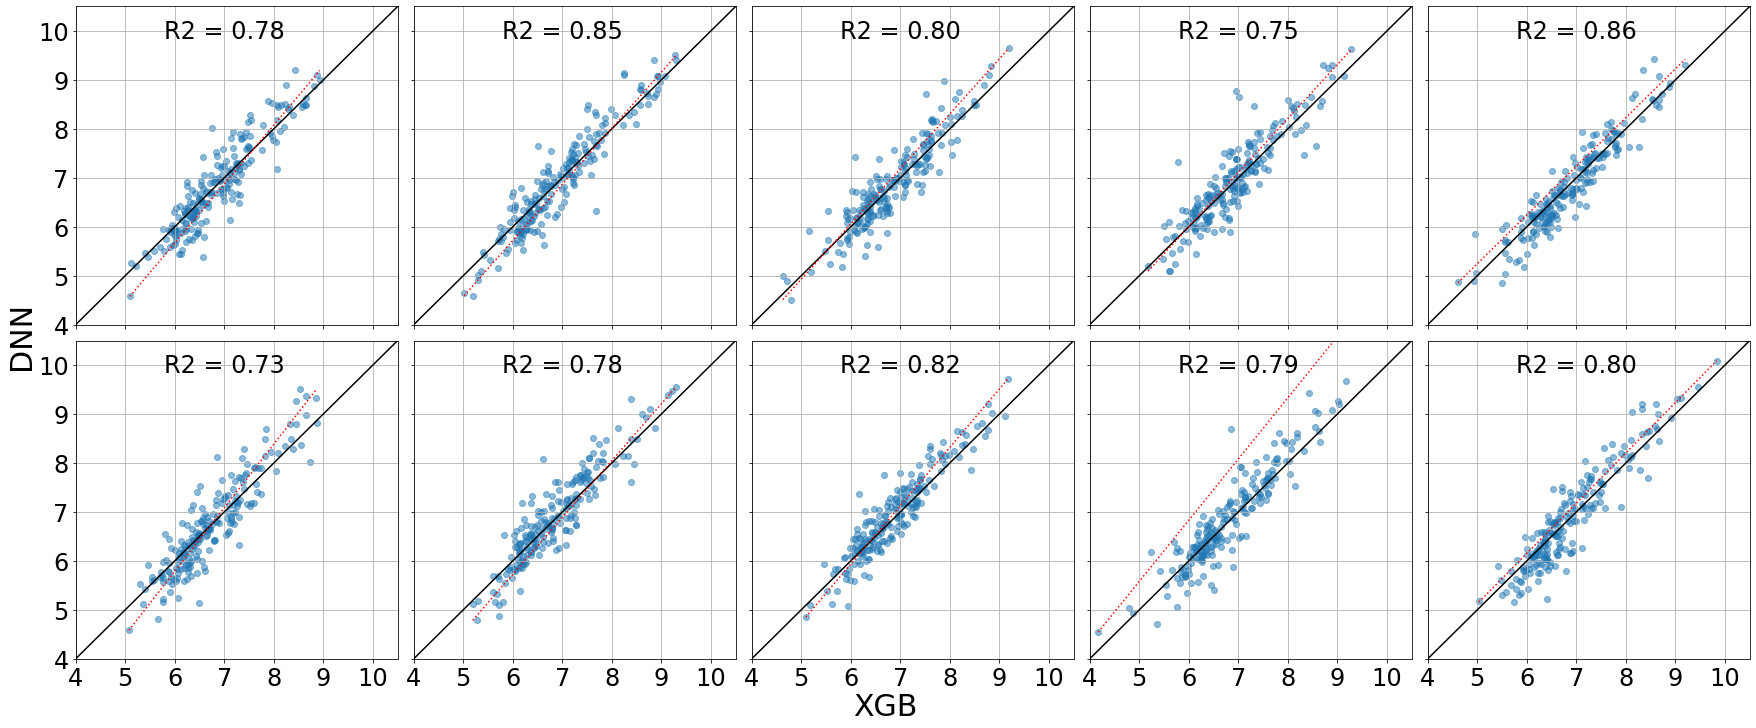

0.79


In [10]:
model = "models_D2"
method1 = "xgb"
method2 = "dnn"
save2png = output_dir+"/DNNxML00_D2_1.png"
get_subplots(model, method1, method2, save2png)

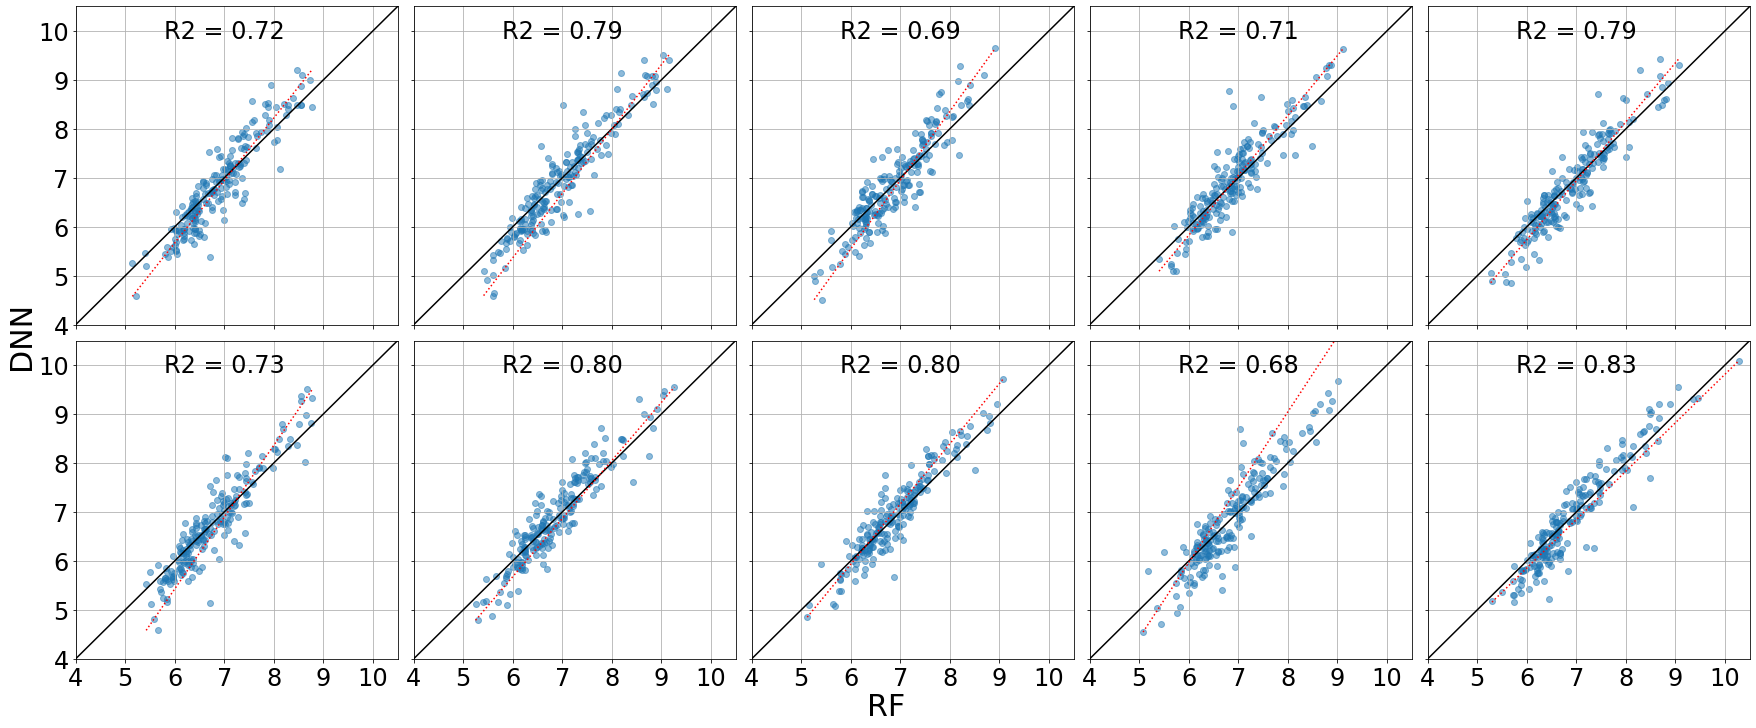

0.76


In [11]:
method1 = "rf"
method2 = "dnn"
save2png = output_dir+"/DNNxML00_D2_2.png"
get_subplots(model, method1, method2, save2png)

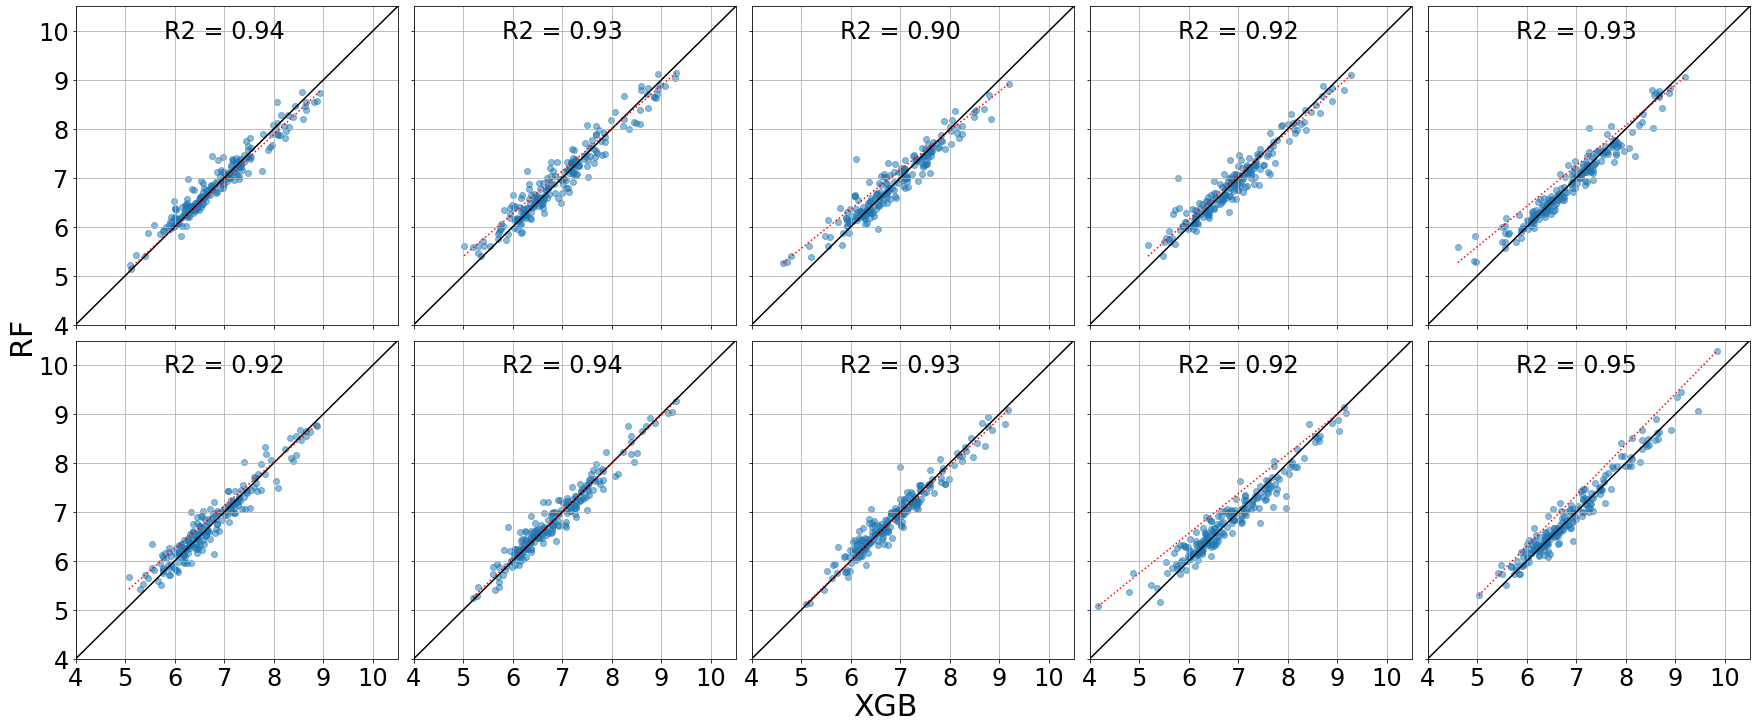

0.93


In [12]:
method1 = "xgb"
method2 = "rf"
save2png = output_dir+"/DNNxML00_D2_3.png"
get_subplots(model, method1, method2, save2png)

# D3

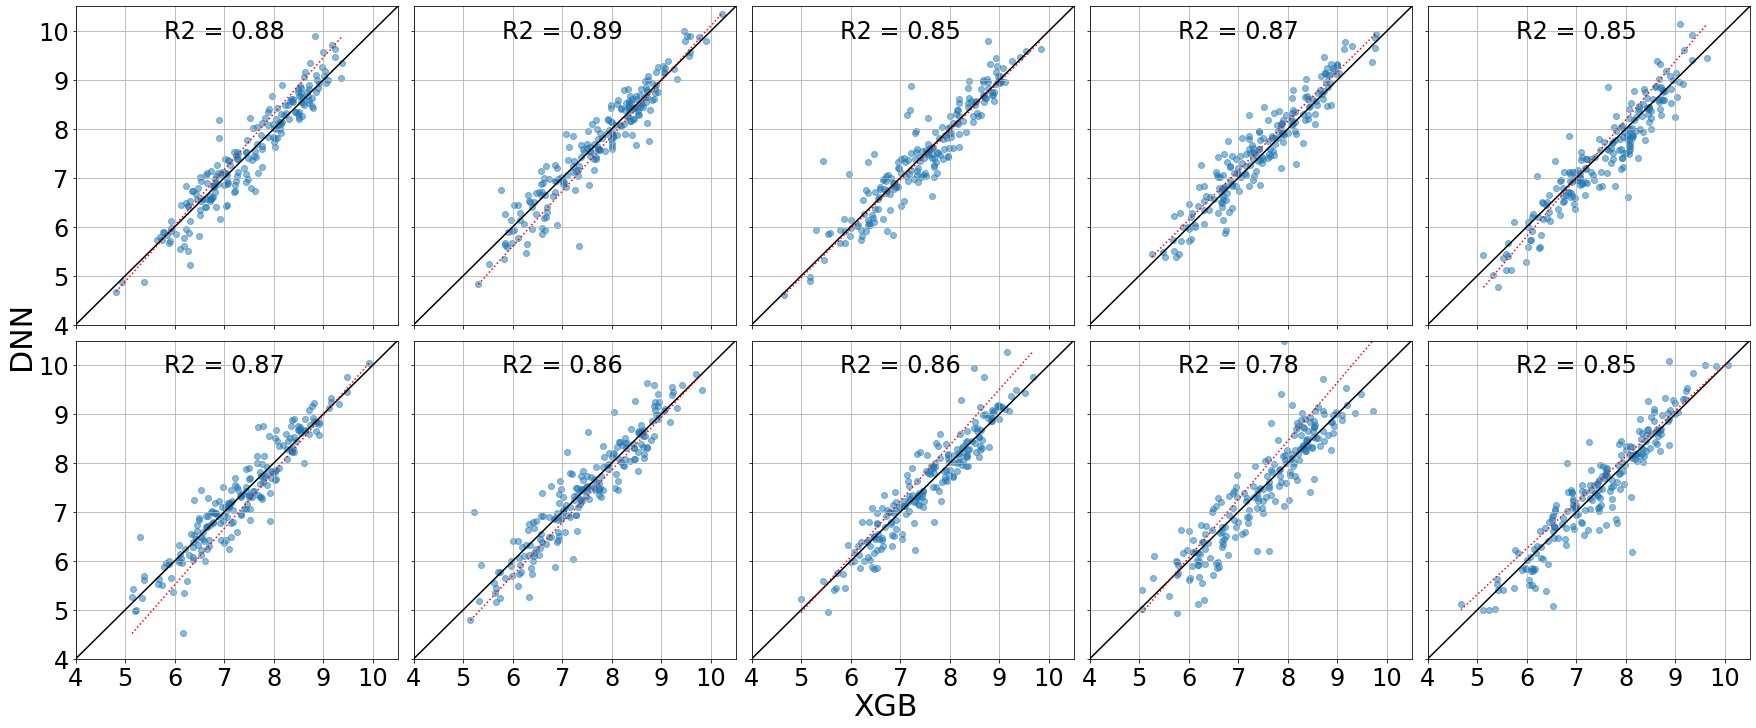

0.86


In [13]:
model = "models_D3"
method1 = "xgb"
method2 = "dnn"
save2png = output_dir+"/DNNxML00_D3_1.png"
get_subplots(model, method1, method2, save2png)

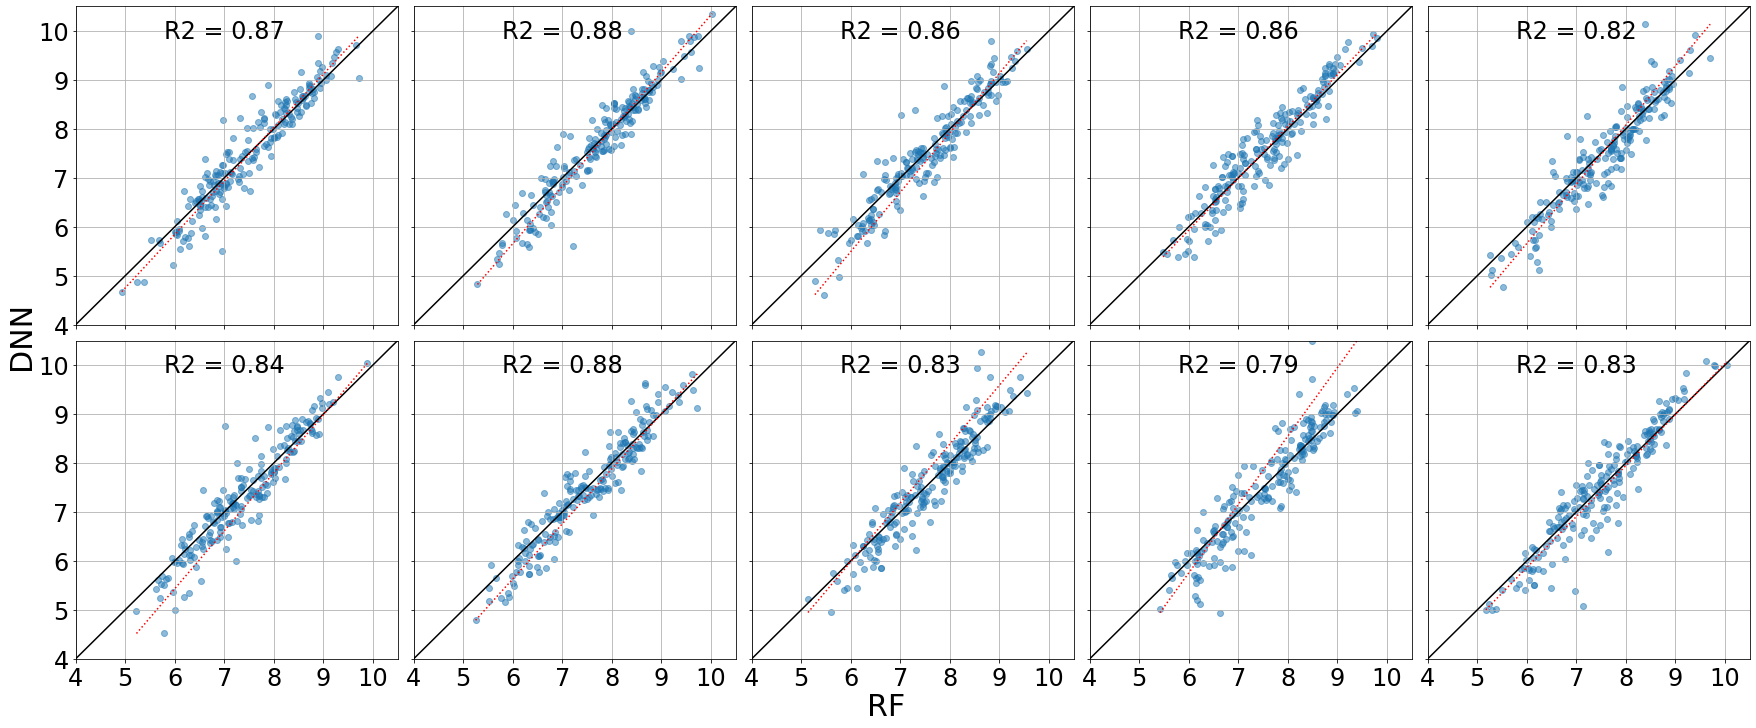

0.85


In [14]:
method1 = "rf"
method2 = "dnn"
save2png = output_dir+"/DNNxML00_D3_2.png"
get_subplots(model, method1, method2, save2png)

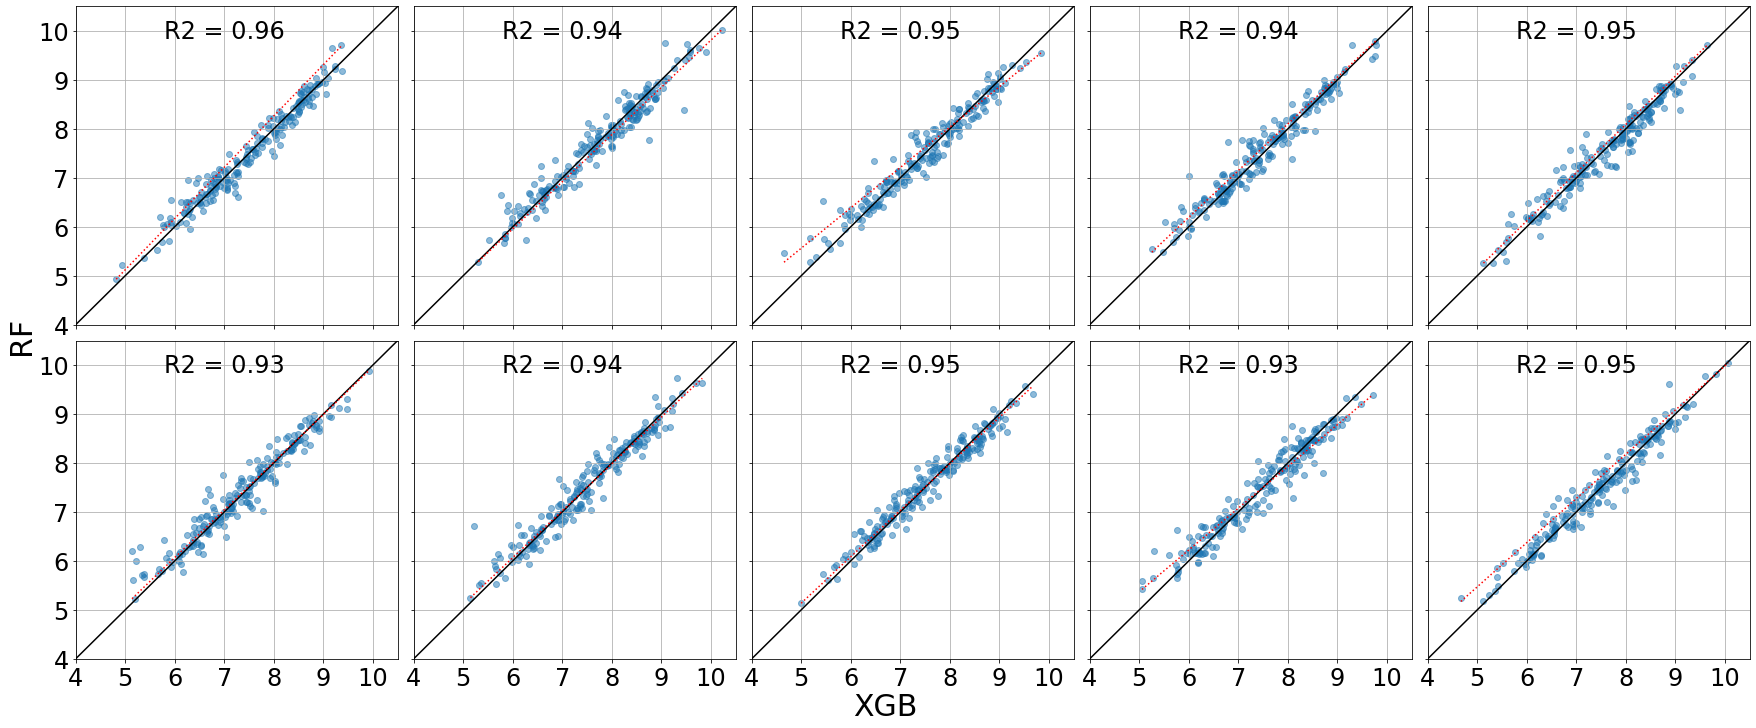

0.94


In [15]:
method1 = "xgb"
method2 = "rf"
save2png = output_dir+"/DNNxML00_D3_3.png"
get_subplots(model, method1, method2, save2png)

# Ratio

In [16]:
    
def get_subplots_selectivity(model, method1, method2, save2png):
    # Create a 2x5 subplot grid with square subplots
    fig, axs = plt.subplots(2, 5, figsize=(30, 12), sharex=True, sharey=True)
    fig.subplots_adjust(hspace=0.05, wspace=0.05)  # Adjust hspace to minimize space between top and bottom subplots

    # Loop through different values of i and plot on the corresponding subplot
    ls_R2 = []
    for i in range(10):
        # Get merged DataFrame for the current i
        df = get_merged_df(model, i)

        # Calculate subplot position
        row = i // 5
        col = i % 5

        # Plot on the current subplot
        axs[row, col].scatter(df[method1], df[method2], alpha=0.5)
        x_values = np.linspace(-4, 3, 100)  # Adjust the range as needed
        axs[row, col].plot(x_values, x_values, linestyle='-', color='black', label='y=x Line')
        axs[row, col].plot([df[method1].min(), df[method1].max()], [df[method2].min(), df[method2].max()], linestyle='dotted', color='red')
        #axs[row, col].tick_params(axis='both', labelsize=16)
        axs[row, col].set_xlim(-4, 3)
        axs[row, col].set_ylim(-4, 3)
        axs[row, col].grid(True)   
        # R2
        Rp, Rs, R2, RMSE = stats(list(df[method1]), list(df[method2]))
        axs[row, col].text(0.65, 0.9, f'R2 = {R2:.2f}', transform=axs[row, col].transAxes, fontsize=24, ha='right')
        ls_R2.append(R2)

        # Set tick locations and increase both x and y-axis tick label font size
        axs[row, col].set_xticks(np.arange(-4, 4, 1))
        axs[row, col].set_yticks(np.arange(-4, 4, 1))
        axs[row, col].tick_params(axis='both', labelsize=24)  # Adjust the labelsize as needed

    # Add common x and y labels for the entire subplot
    if not save2png:
        fig.text(0.5, 0.9, "D3-Selective", ha='center', va='center', fontsize=24)
    fig.text(0.5, 0.07, method1.upper(), ha='center', va='center', fontsize=30)
    fig.text(0.1, 0.5, method2.upper(), ha='center', va='center', rotation='vertical', fontsize=30)

    # Show the entire plot
    plt.savefig(save2png, bbox_inches='tight', transparent = True, dpi = 300)   
    plt.show()
    
    print(round(statistics.mean(ls_R2), 2))


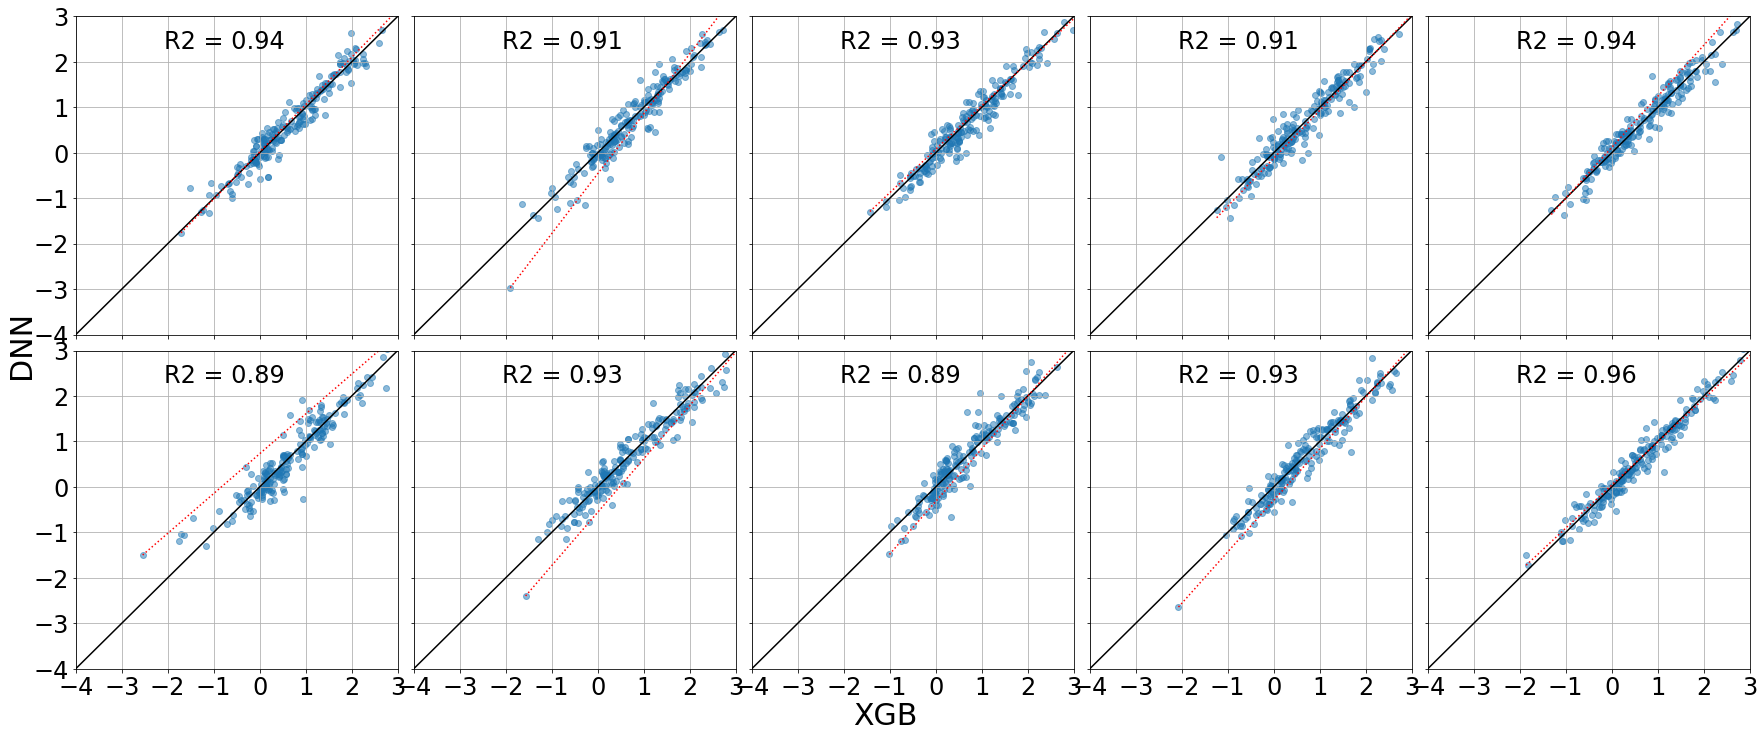

0.92


In [17]:
model = "models__ratio_D2D3"
method1 = "xgb"
method2 = "dnn"
save2png = output_dir+"/DNNxML00_D2D3_1.png"
get_subplots_selectivity(model, method1, method2, save2png)

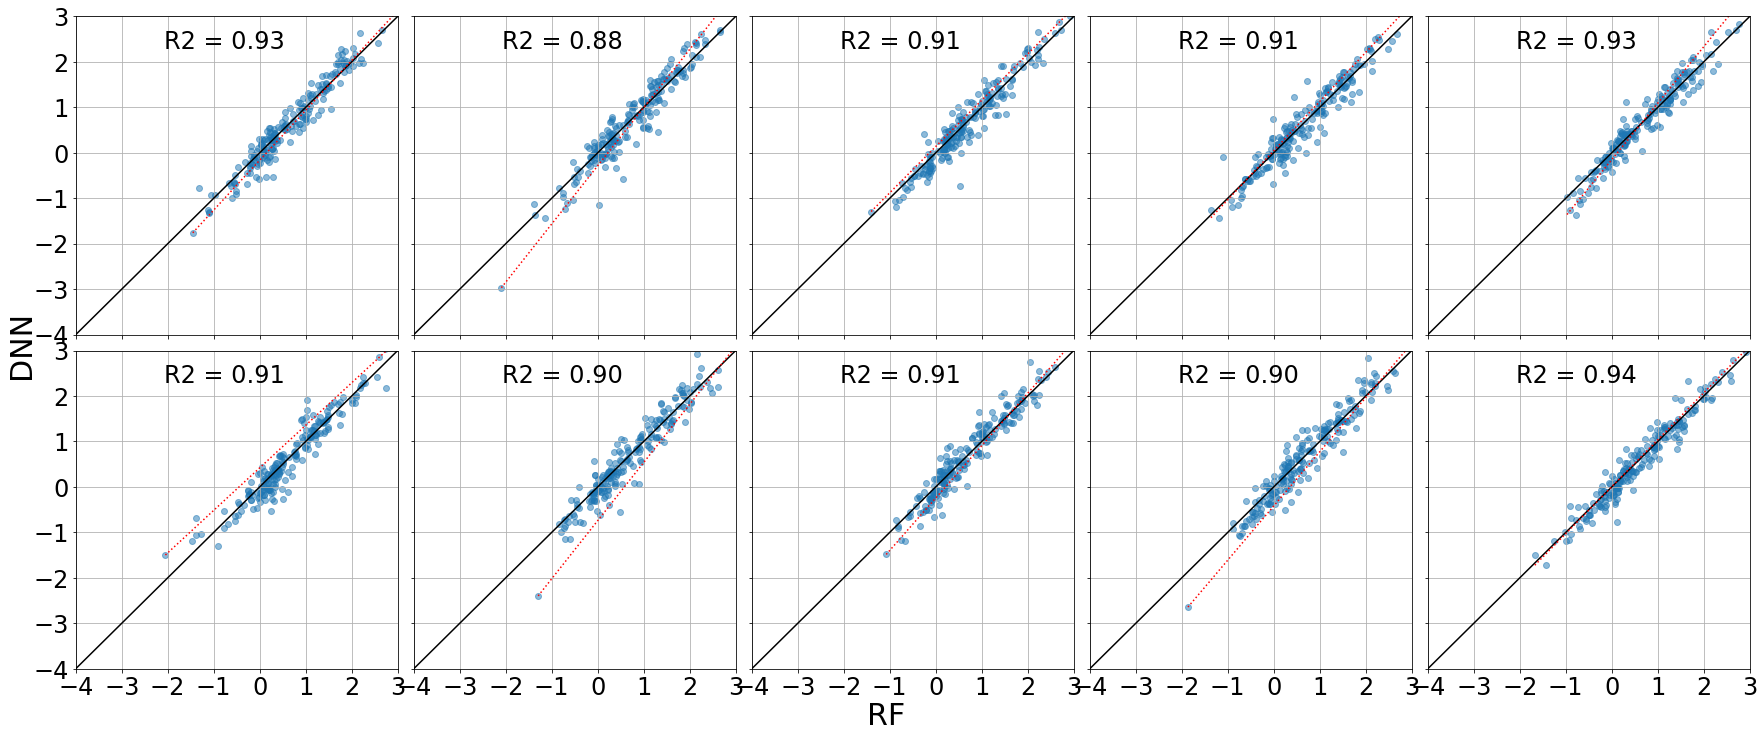

0.91


In [18]:
method1 = "rf"
method2 = "dnn"
save2png = output_dir+"/DNNxML00_D2D3_2.png"
get_subplots_selectivity(model, method1, method2, save2png)

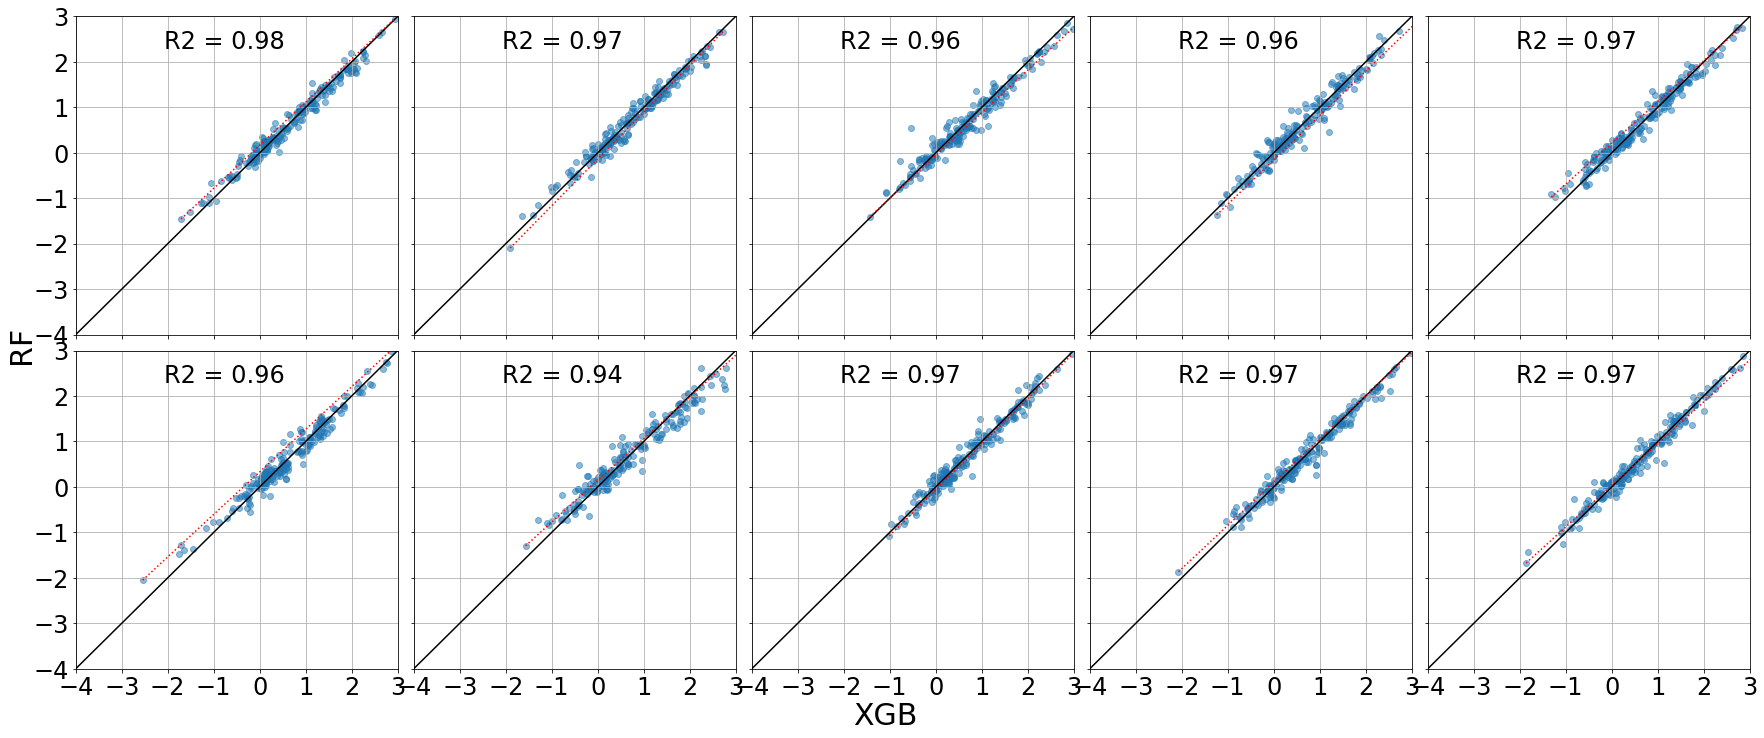

0.96


In [19]:
method1 = "xgb"
method2 = "rf"
save2png = output_dir+"/DNNxML00_D2D3_3.png"
get_subplots_selectivity(model, method1, method2, save2png)